## Feedback control parameter tuning

This is the scikit-learn application for feedback control parameter (example of budget pacing)

In [ ]:
!pip install scikit-learn

In [2]:
from collections import namedtuple

History = namedtuple('History', ('last_clock', 'last_error'))


class PidController(object):
    def __init__(self, kp, ki, kd, clamp):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.clamp = clamp
        self.history = None
        self.integral = 0.0

    def computeOutput(self, current_clock, setpoint, process_variable):
        error = setpoint - process_variable
        if self.history:
            dt = current_clock - self.history.last_clock
            self.integral += error * dt
            derivative = (error - self.history.last_error) / dt
            ret = self.kp * error + self.ki * self.integral + self.kd * derivative
        else:
            ret = None
        self.history = History(current_clock, error)
        return ret

class Actuator(object):
    def __init__(self, initial_value):
        self.value = initial_value

    def next_input(self, output):
        self.value += output
        return self.value


In [3]:
import random

period = 1000000

BidRequest = namedtuple('BidRequest', ('ts', 'threshold'))

def expected_spent(total_budget, clock, period):
    return total_budget * (clock / period)


class AdExchange(object):
    def __init__(self):
        random.seed(0)

    def generate_bid_requests(self):
        current_clock = 0.0
        while current_clock < period:
            bid_request = BidRequest(current_clock, random.randrange(100))
            current_clock += random.randint(2, 10)
            yield bid_request


class Bidder(object):
    def __init__(self, total_budget, kp, ki, kd, clamp):
        self.spent = 0
        self.total_budget = total_budget
        self.bid_price = 10
        self.controller = PidController(kp, ki, kd, clamp)
        self.actuator = Actuator(1)
        random.seed(0)

    def _spend(self):
        self.spent += self.bid_price

    def budget(self, bid_request):
        if self.bid_price > bid_request.threshold:
            self._spend()

        current_clock = bid_request.ts
        expected = expected_spent(self.total_budget, current_clock, period)
        output = self.controller.computeOutput(current_clock, expected, self.spent)
        if output:
            self.bid_price = self.actuator.next_input(output)

        return self.spent


from sklearn.base import BaseEstimator, RegressorMixin

class BidderWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, total_budget, kp=0, ki=0, kd=0, clamp=(0, 0)):
        self.total_budget = total_budget
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.clamp = clamp

    def fit(self, X, y):
        self._reinitialize()
        return self

    def _reinitialize(self):
        self.bidder = Bidder(self.total_budget, self.kp, self.ki, self.kd, self.clamp)

    def predict(self, X):
        return np.array([self.bidder.budget(bid_request) for bid_request in X])

    def reset(self):
        controller = self.bidder.controller
        self.bidder = Bidder(self.bidder.total_budget, controller.kp, controller.ki, controller.kd, controller.clamp)


In [4]:
total_budget = 1000000
reqs = list(AdExchange().generate_bid_requests())
label_dict = dict(map(lambda x: (x.ts, expected_spent(total_budget, x.ts, period)), reqs))
labels = list(label_dict.values())

In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

parameters = {
    'kp': [8e-1, 9e-1],
    'ki': [1e-8, 2e-8],
    'kd': [1.9e-3, 1.8e-3],
    'clamp': [(-0.9, 0.9)]
}

bidder = GridSearchCV(BidderWrapper(total_budget), parameters, cv=2)
bidder.fit(reqs * 2, labels * 2)
best = bidder.best_estimator_
print(bidder.best_params_)

{'clamp': (-0.9, 0.9), 'kd': 0.0018, 'ki': 2e-08, 'kp': 0.8}


In [6]:
%matplotlib inline
import seaborn as sns

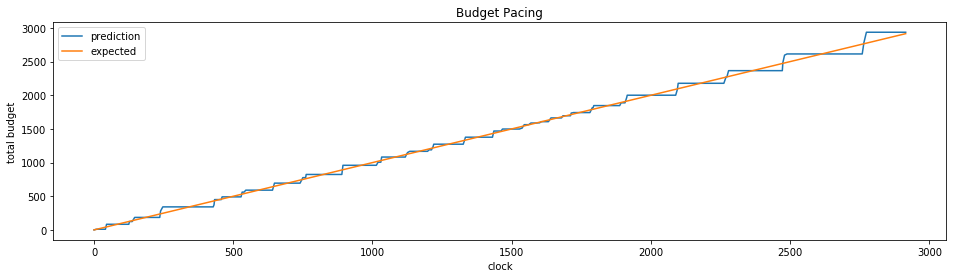

In [7]:
import pandas as pd
best.reset()

rs = reqs[:500]
ls = labels[:len(rs)]
ts = list(map(lambda x: x.ts, rs))

plt.figure(figsize=(16,4))
plt.plot(ts, best.predict(rs), label='prediction')
plt.plot(ts, ls, label='expected')

plt.legend()
plt.title("Budget Pacing")
plt.xlabel("clock")
plt.ylabel("total budget")
plt.show()
